<a href="https://colab.research.google.com/github/emukans/minGPT-translator/blob/master/minGPT_EN_LV_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

if not os.path.isdir('minGPT-translator'):
    !git clone https://github.com/emukans/minGPT-translator.git
    !mv minGPT-translator/checkpoints/* ./


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import urllib
import re
import random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
from torch.nn import functional as F

from collections import OrderedDict, Counter

##MinGPT

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

def calculate_attention_token(attention, top_k, model):
    logits = model.head(attention)
    logits = logits[:, -1, :]
    logits = top_k_logits(logits, top_k)

    probs = F.softmax(logits)

    _, ix = torch.topk(probs, k=1, dim=-1)
    ix = torch.multinomial(probs, num_samples=top_k)

    return ix[0]


@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, output_attention=False):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    attention_state = [[] for _ in model.blocks]

    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)

        if output_attention:
            b, t = x.size()

            for block_id in range(len(model.blocks)):
                att = model.blocks[block_id].attn.att
                attention_state[block_id].append(att)

        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    if output_attention:
        return x, attention_state

    return x


In [4]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.att = None

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))

        self.att = att

        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [5]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import math
import logging

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()


In [6]:
# Read Hemingway texts from URL. There are Hemingway's "A Farewell to arms"
text_input = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_en_small.txt').read().decode("utf-8", "ignore")
text_output = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_lv_small.txt').read().decode("utf-8-sig", "ignore")

In [7]:
class Tokenizer:
    def __init__(self, data, vocab_size, vocab=None):
        self.vocab_size = vocab_size
        if vocab:
            self.vocab = vocab
            self.vocab_size = len(vocab)
        else:
            self.vocab = self.build_vocab(data)

        self.stoi = {ch: i for i, ch in enumerate(self.vocab)}
        self.itos = {i: ch for i, ch in enumerate(self.vocab)}
    
    def sort_vocab(self, vocab):
        """
        Vocab should have the followind order: hashtag, numbers, characters sorted by length.
        Hashtags should go first, because they will be used as dividers on tokenization step.
        Numbers should go before characters, because token ids are numbers. Otherwise token ids will be considered as usual numbers and replaced twice.
        """
        sorted_vocab = sorted(vocab, key=lambda x: len(x), reverse=True)
        tag = [int(s) for s in sorted_vocab if s == '#']
        
        numeric = [int(s) for s in sorted_vocab if s.isnumeric()]
        numeric = [str(s) for s in sorted(numeric, reverse=True)]
        rest = [s for s in sorted_vocab if not s.isnumeric()]
        
        sorted_vocab = tag + numeric + rest
        
        return sorted_vocab
    
    def build_vocab(self, data):
        """
        Build vocabluary using BPE alghorithm.
        """
        vocab = set(data)
        if len(vocab) > self.vocab_size:
            raise ValueError('Vocab size should be greater than unique char count')

        # check all available characters
        char_set = {c for c in vocab if c.isalpha()}
        
        # candidates dictionary will contain a set of all available tokens to search
        candidate_dict = dict().fromkeys(char_set, 0)
        
        # occurrences will contain all matched tokens and the count, how many times the token has been found.
        token_occurrences = OrderedDict()
        while len(vocab) < self.vocab_size:
            for candidate in candidate_dict.keys():
                occurrences = data.count(candidate)
                candidate_dict[candidate] = occurrences

            candidate_dict = {candidate: count for candidate, count in candidate_dict.items() if count}
            vocab.update(set(candidate_dict.keys()))
            token_occurrences.update(candidate_dict)

            # build new candidates
            temp_candidate_set = set()
            for char in char_set:
                # don't test candidates with occurency <= 2. New candidates won't have occurency higher than 2
                temp_candidate_set.update({candidate + char for candidate in candidate_dict.keys() if token_occurrences[candidate] > 2})

            candidate_dict = dict().fromkeys(temp_candidate_set, 0)

        tokens_to_remove = len(vocab) - self.vocab_size
        token_occurrences = OrderedDict(sorted(token_occurrences.items(), key=lambda x: x[1], reverse=True))
        for _ in range(tokens_to_remove):
            token, _ = token_occurrences.popitem()
            vocab.remove(token)

        sorted_vocab = self.sort_vocab(vocab)
        
        # add a special token for unknown tokens
        sorted_vocab.append('<unk>')
        self.vocab_size += 1 # plus <unk> special token
        
        # add end of sentence special token
        sorted_vocab.append('<eos>')
        self.vocab_size += 1 # plus <eos> special token
        
        return sorted_vocab
    
    def tokenize(self, data, block_size):
        for token in self.vocab:
            data = data.replace(token, f'#{self.stoi[token]}#')

        # If everything went well, first and last characters won't have # pair. Need to trim them
        data = data[1:-1]
        # Split by ## pairs
        tokenized_text = data.split('##')
        # Filter empty strings
        tokenized_text = [x for x in tokenized_text if x]
        result = []
        for tokenized in tokenized_text:
            # In case other single # found, replace them with <unk> special token, marking the element as unknown
            if '#' in tokenized:
                for unknown_candidate in tokenized.split('#'):
                    if unknown_candidate.isnumeric():
                        result.append(self.itos[int(unknown_candidate)])
                    else:
                        result.append('<unk>')
            else:
                result.append(self.itos[int(tokenized)])

        # in case the sentence is longer, than block_size, we trim the sentence
        return result[:block_size]
    
    def encode(self, data):
        return [self.stoi[s] for s in data]
    
    def decode(self, data):
        return ''.join([self.itos[int(i)] for i in data])

In [8]:
vocab_size = 10000

vocab_input = None
if os.path.exists('vocab_input.pkl'):
    with open('vocab_input.pkl', 'rb') as f:
        vocab_input = pickle.load(f)
        
vocab_output = None
if os.path.exists('vocab_output.pkl'):
    with open('vocab_output.pkl', 'rb') as f:
        vocab_output = pickle.load(f)

# building vocabluary can take some time. ~5 minutes for 10_000 tokens for each tokenizer. 
tokenizer_input = Tokenizer(text_input, vocab_size, vocab_input)
tokenizer_output = Tokenizer(text_output, vocab_size, vocab_output)

In [9]:
with open('vocab_input.pkl', 'wb') as f:
    pickle.dump(tokenizer_input.vocab, f)

with open('vocab_output.pkl', 'wb') as f:
    pickle.dump(tokenizer_output.vocab, f)

In [10]:
# Shuffle texts by lines
texts = list(zip(text_output.splitlines(), text_input.splitlines()))
random.shuffle(texts)

text_output, text_input = zip(*texts)

In [11]:
# Split texts into train, test and validation datasets
train_dataset_size = round(0.85 * len(text_output))
test_dataset_size = round(0.1 * len(text_output))
valid_dataset_size = round(0.05 * len(text_output))

train_input = text_input[:train_dataset_size]
test_input = text_input[train_dataset_size:train_dataset_size + test_dataset_size]
valid_input = text_input[-valid_dataset_size:]

train_output = text_output[:train_dataset_size]
test_output = text_output[train_dataset_size:train_dataset_size + test_dataset_size]
valid_output = text_output[-valid_dataset_size:]


In [12]:
from torch.utils.data import Dataset

class WordDataset(Dataset):

    def __init__(self, output_text, input_text, tokenizer_output, tokenizer_input, block_size):
        self.tokenizer_output = tokenizer_output
        self.tokenizer_input = tokenizer_input

        self.block_size = block_size * 2 + 1
        self.output_text = [tokenizer_output.tokenize(t, block_size) for t in output_text]
        self.input_text = [tokenizer_input.tokenize(t, block_size) for t in input_text]

    def __len__(self):
        return len(self.output_text)

    def __getitem__(self, idx):
        """
        The idea is to get the input sentence
        and translate it to output sentence (sentences could be on any language).

        In the init method we already split a sentence into tokens and filled with spaces,
        to have an equal sentence size. In this method we just encode the tokens to
        ids (a list of numbers), and we're trying to map ids sequences
        """

        tokenized_input_text = self.tokenizer_input.encode(self.input_text[idx])
        tokenized_output_text = self.tokenizer_output.encode(self.output_text[idx])

        dix = tokenized_input_text + self.tokenizer_output.encode(['<eos>']) + tokenized_output_text
        if len(dix) < self.block_size:
            dix += self.tokenizer_output.encode([' ']) * (self.block_size - len(dix))

        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        y[:len(tokenized_input_text) - 1] = -100

        return x, y

In [13]:
block_size = 100  # the estimate how long lines the text could be (token count)
number_of_heads = 4
number_of_layers = 2

train_dataset = WordDataset(train_output, train_input, tokenizer_output, tokenizer_input, block_size)
test_dataset = WordDataset(test_output, test_input, tokenizer_output, tokenizer_input, block_size)

In [14]:
# from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(tokenizer_output.vocab_size, train_dataset.block_size,
                  n_layer=number_of_layers, n_head=number_of_heads, n_embd=512)
model = GPT(mconf)

In [15]:
# from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_dataset) * block_size
train_epochs = 50

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=64, learning_rate=3e-4,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='translator_model.pt',
                      num_workers=1)
trainer = Trainer(model, train_dataset, test_dataset, tconf)

In [16]:
# trainer.train()

In [17]:
checkpoint = torch.load('translator_model.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [18]:
from random import choice

for _ in range(5):
    idx = choice(range(len(valid_output)))

    context = valid_input[idx]
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1

    predicted = y[intent:]
    completion = tokenizer_output.decode(predicted)
    print(f'Input:            {context}')
    print(f'Predicted output: {completion}')
    print(f'Real output:      {valid_output[idx]}')
    print('--------------------------------------------------')

Input:            I've vomited into a gas mask.
Predicted output: Es izdzēru ar galvu.                                                                                        
Real output:      Esmu pat vēmis gāzmaskā.
--------------------------------------------------
Input:            I will have ten drinks.
Predicted output: Es desmit desmit desmit malku                                                                                   
Real output:      Es dzeru desmit glāzes.
--------------------------------------------------
Input:            "And you play it as well as you know how.
Predicted output: "Un tu pats to labi to to zināt, ka nevar esat  kā                                                                       
Real output:      "Bet tu tēlo un pats labi zini.
--------------------------------------------------
Input:            she asked after she had done something for me very skilfully.
Predicted output: viņa jautāja mani kaut ko noskūpstīja, vai vai ne?                

In [19]:
idx = choice(range(len(valid_output)))

context = valid_input[idx]
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')
print(f'Real output:      {valid_output[idx]}')
print('--------------------------------------------------')


Input:            "It's all right, Cat."
Predicted output: "Tas labi, Ket."                                                                                          
Real output:      "Labi vien ir, Ket."
--------------------------------------------------


In [20]:
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = []

for token in encoded_input:
    axis_text.append(tokenizer_input.decode([token]))

    if axis_text[-2:].count(' ') == 2:
        axis_text = axis_text[:-1]
        break

axis_text.append('<eos>')

for token in predicted:
    axis_text.append(tokenizer_output.decode([token]))

    if axis_text[-2:].count(' ') == 2:
        axis_text = axis_text[:-1]
        break

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()

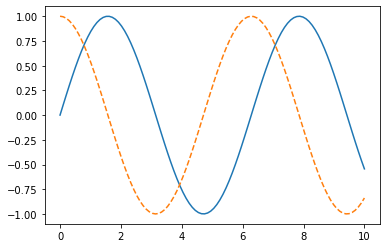

In [25]:
# %matplotlib inline
# import numpy as np
# x = np.linspace(0, 10, 100)

# fig = plt.figure()
# plt.plot(x, np.sin(x), '-')
# plt.plot(x, np.cos(x), '--');

In [22]:
!pip install bleu

  Created wheel for bleu: filename=bleu-0.3-cp37-none-any.whl size=5802 sha256=f3c7dd6ca65978d992bd25948e88d6c9a54004ef143bb348a84981549d4ce53e
  Stored in directory: /root/.cache/pip/wheels/a9/95/e7/cb43a1c509c38fedbee6223963e34a51a94d8991f3b3e1888e
  Created wheel for efficiency: filename=efficiency-0.5-cp37-none-any.whl size=20285 sha256=c6f63b10b65a13c9febf0c1f3c3189d3ea665c8a76f8ad434749bb95705b298f
  Stored in directory: /root/.cache/pip/wheels/94/fd/e6/2d34e80768fb2d001fc35b033a48114b1afdb6ea020b4cb2c7
Successfully built bleu efficiency


In [23]:
from bleu import list_bleu

bleu_results = []
for idx, context in enumerate(valid_input):
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1
    predicted = y[intent:]
    completion = tokenizer_output.decode(predicted)

    bleu = list_bleu([[valid_output[idx]]], [completion])
    bleu_results.append(bleu)

print(f"Averare BLEU: {np.mean(bleu_results)}")

Averare BLEU: 5.313061224489797


Enter your English text to translate: I will have to drink
Input:            I will have to drink
Predicted output: dzeršu.                                                                                                


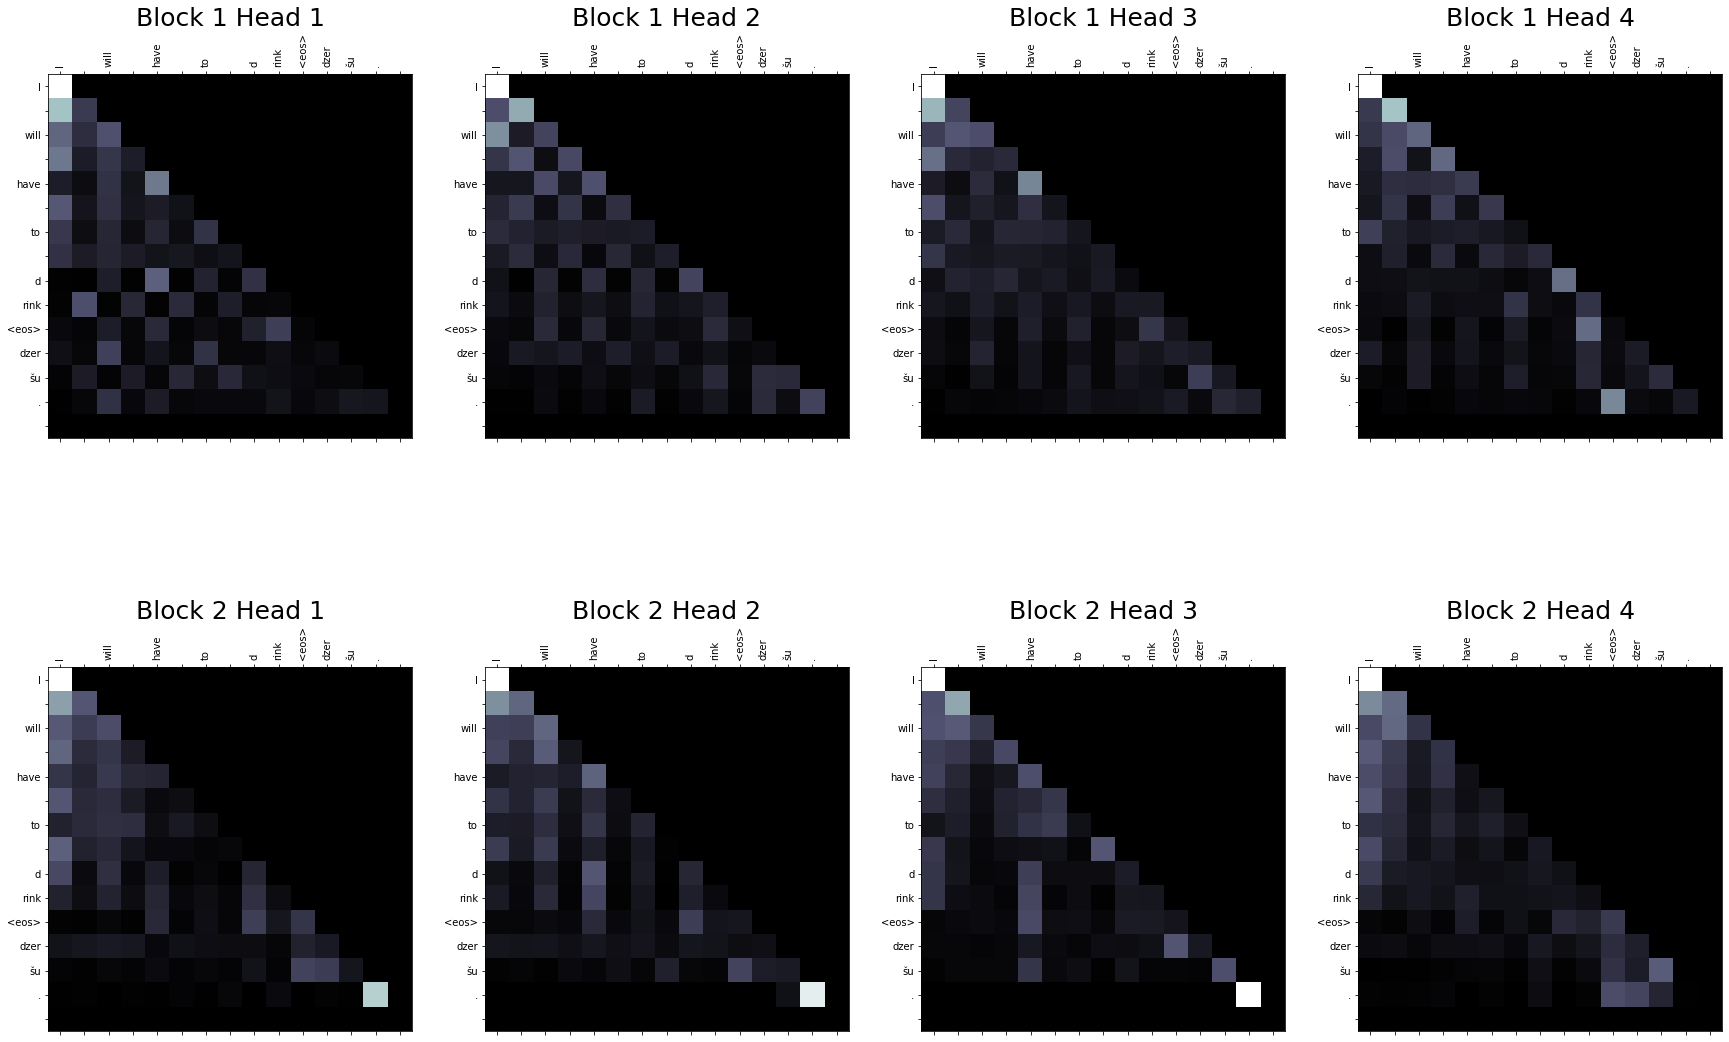

In [26]:
context = input("Enter your English text to translate: ")

# Predict Latvian output
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')


# Plot attention
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = []

for token in encoded_input:
    axis_text.append(tokenizer_input.decode([token]))

    if axis_text[-2:].count(' ') == 2:
        axis_text = axis_text[:-1]
        break

axis_text.append('<eos>')

for token in predicted:
    axis_text.append(tokenizer_output.decode([token]))

    if axis_text[-2:].count(' ') == 2:
        axis_text = axis_text[:-1]
        break

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()